sys: 12 CPUs, 16 GB RAM
GPU: 6 GB
Number of workers: 1
Calculating with 1e+08 points



<IPython.core.display.Javascript object>


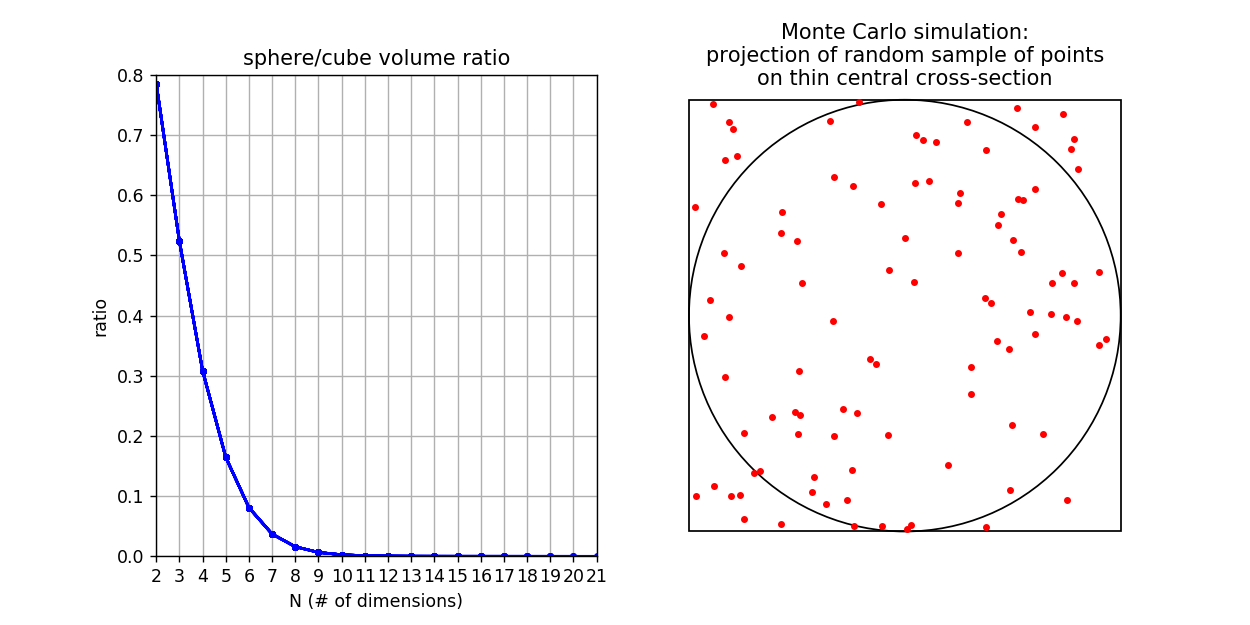

dims	ratios
2	0.785388
3	0.523512
4	0.308464
5	0.164432
6	0.0807675
7	0.0369043
8	0.0158703
9	0.00644008
10	0.00249403
11	0.00092044
12	0.00032881
13	0.00011037
14	3.628e-05
15	1.204e-05
16	3.82e-06
17	9.7e-07
18	2.3e-07
19	1e-07
20	6e-08
21	0

Execution time: 58.042 sec


In [1]:
# code
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
import gc
import psutil
import multiprocessing
from multiprocessing import Pool
import time
from pprint import pprint
# for multiprocessing on iPython,
# workers need to be in separate modules
from xpu_workers import make_dots


# due to how multiprocessing works with iPython and/or Windows
# we need to wrap the main code under __main__
# this would not be necessary with pure Python on Unix
if __name__ == '__main__':
    tstart = int(round(time.time() * 1000))
    # set variables
    d_max = 31
    
    # total number of points used for the simulation
    points = 10 ** 8
    
    dims = []
    ratios = []
    
    # figure out the system
    num_p = multiprocessing.cpu_count()
    sysmem = psutil.virtual_memory()[0]
    memGB = round(sysmem / (1024 ** 3))
    try:
        # look for a GPU
        import cupy as cp
        gpumem = cp.cuda.Device().mem_info[1]
        workers = 1
    except:
        # no usable GPU found, let's use the CPU instead
        gpumem = 0
        workers = num_p
    
    # force the spawn method on all OSes
    # without it, on Unix all workers will make identical "random" sequences
    # which lowers the entropy of the sample
    # spawn makes sure Numpy generates independent RNG sequences for workers
    multiprocessing.set_start_method('spawn')
    
    print('sys:', num_p, 'CPUs,', memGB, 'GB RAM')
    print('GPU:', round(gpumem / (1024 ** 3)), 'GB')
    print('Number of workers:', workers)
    print("Calculating with %g points" % points)
    print()
    
    # initialize plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_xlabel('N (# of dimensions)')
    ax1.set_ylabel('ratio')
    ax1.set_title('sphere/cube volume ratio')
    ax1.set_ylim(0, 0.8)
    ax1.set_xscale('linear')
    ax1.set_yscale('linear')
    ax1.set_xticks(range(2, d_max))
    ax1.grid()
    square1 = plt.Rectangle((-0.5, -0.5), 1, 1, linewidth = 1, edgecolor='black', facecolor='white')
    circle1 = plt.Circle((0, 0), 0.5, color='black', fill=False)
    
    print('dims\tratios')
    # main loop
    for d in range(2, d_max):
        # create MP pool
        p = Pool(processes = workers)
        
        # multiprocessing.pool.map() only works with one argument,
        # so we make a list of tuples
        # each tuple is an "argument" to a worker
        arglist = [(points, d, workers, sysmem, gpumem)] * workers
        
        # Wake up comrades! For the glory of the Motherland!
        work_out = p.map(make_dots, arglist)
        
        # In Jupyter, if you don't force-close the pool every cycle,
        # you get A LOT of workers just hanging around
        # and the whole thing stops. Kinda like the 1930s.
        p.close()
        
        # parse the output from workers
        p_int = 0
        pts_sample = np.empty((0, d))
        for i in range(workers):
            p_int += work_out[i][0]
            pts_sample = np.concatenate((pts_sample, work_out[i][1]))
        ratio = p_int / points
        dims.append(d)
        ratios.append(ratio)
        
        # plot the ratios
        ax1.set_xlim(2, max(d, 3))
        ax1.plot(dims, ratios, '.b-')
        
        # plot the sample dots
        ax2.clear()
        ax2.set_aspect(1.0)
        ax2.set_xscale('linear')
        ax2.set_yscale('linear')
        ax2.set_axis_off()
        ax2.set_xlim(-0.51, 0.51)
        ax2.set_ylim(-0.51, 0.51)
        ax2.set_title('Monte Carlo simulation:\nprojection of random sample of points\non thin central cross-section')
        ax2.add_artist(square1)
        ax2.add_artist(circle1)
        ax2.plot(pts_sample[:, 0], pts_sample[:, 1], '.r')
        del pts_sample
        
        # update the figure (actually update the plots on screen)
        fig.canvas.draw()
        print("%d\t%g" % (d, ratio))
        
        # memory usage is critical, so let's force a cleanup every cycle
        gc.collect()
        
        # if no points are detected inside the sphere anymore, then let's stop
        if p_int == 0:
            break
    
    tend = int(round(time.time() * 1000))
    print('\nExecution time:', (tend - tstart) / 1000, 'sec')
